In [54]:
import os 
import napari
from tqdm import tqdm
import numpy as np
import napari
import glob2 as glob
import os
import skimage.io as io
import nd2
from skimage.morphology import label
from skimage.measure import regionprops
import zarr
from scipy.spatial import KDTree
import skimage.graph as graph
from skimage.transform import resize
import skimage as ski
import SimpleITK as sitk
import networkx as nx
import pandas as pd
from fin_morphodynamics.src.utilities.image_utils import calculate_LoG

## Load and process small test dataset

In [66]:
root = "E:\\Nick\Cole Trapnell's Lab Dropbox\\Nick Lammers\\Nick\pecfin_dynamics\\fin_morphodynamics\\"

experiment_date = "20240223"
model_name = "log-v5"
label_directory = os.path.join(root, "built_data", "cellpose_output", model_name, experiment_date, '')
data_directory = os.path.join(root, "built_data", "zarr_image_files", experiment_date, '')

# get list of images
image_list = sorted(glob.glob(data_directory + "*.zarr"))
time_int = 101
well_int = 12

# load raw data 
data_tzyx = zarr.open(image_list[well_int], mode="r")
data_zyx = np.squeeze(data_tzyx[time_int, :, :, :])

dtype = data_zyx.dtype
scale_vec = tuple([2.0, 0.55, 0.55])

# load the origianl labels and probs generated by CellPose
prob_name = experiment_date + f"_well{well_int:03}_t{time_int:03}_probs.tif"
label_name = experiment_date + f"_well{well_int:03}_t{time_int:03}_labels.tif"

# prob_path = os.path.join(label_directory, prob_name)
# im_prob = io.imread(prob_path)
# label_path = os.path.join(label_directory, label_name)
# im_label = io.imread(label_path)

# Crop to a more managable size 
# data_cropped = data_zyx[:, 340:590, 90:270] # for well02 time 201
# labels_cropped = im_label[:, 340:590, 90:270]
# probs_cropped = im_prob[:, 340:590, 90:270]

# data_cropped = data_zyx[:, 500:775, 130:475] # for well 12 time00
# labels_cropped = im_label[:, 500:775, 130:475]
# probs_cropped = im_prob[:, 500:775, 130:475]

data_cropped = data_zyx[:, 500:775, 90:435] # for well 12 time101
labels_cropped = im_label[:, 500:775, 90:435]
probs_cropped = im_prob[:, 500:775, 90:435]

im_LoG, im_bkg = calculate_LoG(data_cropped, scale_vec, make_isotropic=True)

## Let's take a quick look at the data

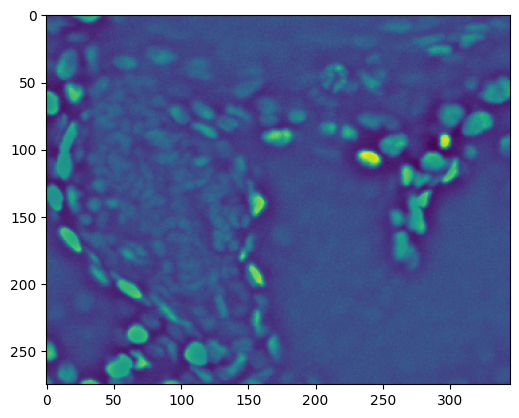

In [67]:
from matplotlib import pyplot as plt

plt.imshow(im_bkg[100])
plt.show()

## Now, let's experiment with omnipose's label stitching

In [68]:
from cellpose import models as cp_models

dim = 2 
use_GPU = True
diameter = 10
# segmentation parameters 
omni = 1
rescale = True
mask_threshold = 0 
net_avg = 0
verbose = 0 
tile = 0
compute_masks = 1
anisotropy = 1.01
flow_threshold=0.
do_3D=True
flow_factor=10
min_size=10
cellprob_threshold=0

pretrained_model = "E:\\Nick\\Cole Trapnell's Lab Dropbox\\Nick Lammers\\Nick\\pecfin_dynamics\\fin_morphodynamics\\built_data\\cellpose_training\\20240223_tdTom\\log\\models\\log-v5"

model = cp_models.CellposeModel(
                            gpu=use_GPU, pretrained_model=pretrained_model)#models.CellposeModel(gpu=use_GPU, pretrained_model=pretrained_model)

mask, flows, styles = model.eval(
            im_LoG,
            channels=[0, 0],
            do_3D=do_3D,
            min_size=min_size,
            diameter=diameter,
            anisotropy=anisotropy,
            cellprob_threshold=cellprob_threshold
        )

2024-03-28 14:14:49,623	[INFO]	models  __init__....()	 line 360	>>>> loading model E:\Nick\Cole Trapnell's Lab Dropbox\Nick Lammers\Nick\pecfin_dynamics\fin_morphodynamics\built_data\cellpose_training\20240223_tdTom\log\models\log-v5
2024-03-28 14:14:49,625	[INFO]	core    _use...torch()	 line 63	** TORCH CUDA version installed and working. **
2024-03-28 14:14:49,626	[INFO]	        assi...evice()	 line 81	>>>> using GPU
2024-03-28 14:14:49,815	[INFO]	models  __init__....()	 line 376	>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-03-28 14:14:49,816	[INFO]	                    	 line 378	>>>> model diam_labels =  8.331 (mean diameter of training ROIs)
multi-stack tiff read in as having 243 planes 1 channels
2024-03-28 14:14:51,401	[INFO]	core    _run_3D.....()	 line 628	running YX: 243 planes of size (275, 345)
100%|##########| 81/81 [00:11<00:00,  7.18it/s]
2024-03-28 14:15:03,922	[INFO]	core    _run_3D.....()	 line 628	running ZY: 275 planes of size (243

## Try affinity seg option

In [69]:
import omnipose 
cellprob=flows[2]
bd = np.zeros_like(cellprob)
dP = flows[1]
mask_threshold = 0
niter = 100
max_size=1e5


masks_aff0, _, _, _, _ = omnipose.core.compute_masks(dP, cellprob,
                                                    do_3D=do_3D,
                                                    niter=niter,
                                                    resize=None,
                                                    boundary_seg=False,
                                                    affinity_seg=True,
                                                    min_size=min_size, 
                                                    max_size=max_size,
                                                    mask_threshold=mask_threshold,  
                                                    diam_threshold=diam_threshold,
                                                    flow_threshold=flow_threshold, 
                                                    flow_factor=flow_factor,      
                                                    interp=True, 
                                                    verbose=True,
                                                    omni=True,
                                                    #cluster=True,
                                                    use_gpu=use_GPU, 
                                                    device='cuda', 
                                                    nclasses=2, 
                                                    dim=3)

2024-03-28 14:16:05,147	[INFO]	core    comp...masks()	 line 1307	mask_threshold is 0
2024-03-28 14:16:05,148	[INFO]	                    	 line 1319	Using hysteresis threshold.
2024-03-28 14:16:05,932	[INFO]	        follow_flows()	 line 1995	niter: 100, interp: True, suppress: False, calc_trace: False
2024-03-28 14:16:06,184	[INFO]	        steps_batch.()	 line 1887	interp is True, interpolation mode is bilinear
2024-03-28 14:16:06,434	[INFO]	        comp...masks()	 line 1422	computing affinity graph
2024-03-28 14:16:18,330	[INFO]	                    	 line 1450	despur disabled
2024-03-28 14:16:18,427	[INFO]	                    	 line 1477	doing affinity seg without cluster.
2024-03-28 14:16:23,932	[INFO]	                    	 line 1614	compute_masks() execution time: 18.8 sec
2024-03-28 14:16:23,933	[INFO]	                    	 line 1615		execution time per pixel: 8.14831e-07 sec/px
2024-03-28 14:16:23,962	[INFO]	                    	 line 1616		execution time per cell pixel: 1.32406e-0

In [74]:
mask_threshold = 6
flow_factor = 1
max_size = 1e5 #13000
masks_aff_6, _, _, _, agumented_affinity = omnipose.core.compute_masks(dP, cellprob,
                                                    do_3D=do_3D,
                                                    niter=niter,
                                                    resize=None,
                                                    boundary_seg=False,
                                                    affinity_seg=True,
                                                    min_size=min_size, 
                                                    max_size=max_size,
                                                    mask_threshold=mask_threshold,
                                                    flow_factor=flow_factor,      
                                                    interp=True, 
                                                    verbose=True,
                                                    omni=True,
                                                    cluster=False,
                                                    use_gpu=use_GPU, 
                                                    device='cuda', 
                                                    nclasses=2, 
                                                    dim=3)

2024-03-28 14:43:01,544	[INFO]	                    	 line 1307	mask_threshold is 6
2024-03-28 14:43:01,545	[INFO]	                    	 line 1319	Using hysteresis threshold.
2024-03-28 14:43:02,338	[INFO]	        follow_flows()	 line 1995	niter: 100, interp: True, suppress: False, calc_trace: False
2024-03-28 14:43:02,625	[INFO]	        steps_batch.()	 line 1887	interp is True, interpolation mode is bilinear
2024-03-28 14:43:02,781	[INFO]	        comp...masks()	 line 1422	computing affinity graph
2024-03-28 14:43:10,837	[INFO]	                    	 line 1450	despur disabled
2024-03-28 14:43:10,905	[INFO]	                    	 line 1477	doing affinity seg without cluster.
2024-03-28 14:43:16,038	[INFO]	                    	 line 1614	compute_masks() execution time: 14.5 sec
2024-03-28 14:43:16,039	[INFO]	                    	 line 1615		execution time per pixel: 6.28683e-07 sec/px
2024-03-28 14:43:16,069	[INFO]	                    	 line 1616		execution time per cell pixel: 1.6013e-05 s

In [72]:
mask_threshold = -6
flow_factor = 1
max_size = 1e5 #13000
masks_aff_n6, _, _, _, _ = omnipose.core.compute_masks(dP, cellprob,
                                                    do_3D=do_3D,
                                                    niter=niter,
                                                    resize=None,
                                                    boundary_seg=False,
                                                    affinity_seg=True,
                                                    min_size=min_size, 
                                                    max_size=max_size,
                                                    mask_threshold=mask_threshold,
                                                    flow_factor=flow_factor,      
                                                    interp=True, 
                                                    verbose=True,
                                                    omni=True,
                                                    cluster=False,
                                                    use_gpu=use_GPU, 
                                                    device='cuda', 
                                                    nclasses=2, 
                                                    dim=3)

2024-03-28 14:19:39,980	[INFO]	                    	 line 1307	mask_threshold is -6
2024-03-28 14:19:39,981	[INFO]	                    	 line 1319	Using hysteresis threshold.
2024-03-28 14:19:40,791	[INFO]	        follow_flows()	 line 1995	niter: 100, interp: True, suppress: False, calc_trace: False
2024-03-28 14:19:41,075	[INFO]	        steps_batch.()	 line 1887	interp is True, interpolation mode is bilinear
2024-03-28 14:19:41,241	[INFO]	        comp...masks()	 line 1422	computing affinity graph
2024-03-28 14:19:58,272	[INFO]	                    	 line 1450	despur disabled
2024-03-28 14:19:58,402	[INFO]	                    	 line 1477	doing affinity seg without cluster.
2024-03-28 14:20:04,654	[INFO]	                    	 line 1614	compute_masks() execution time: 24.7 sec
2024-03-28 14:20:04,655	[INFO]	                    	 line 1615		execution time per pixel: 1.07021e-06 sec/px
2024-03-28 14:20:04,684	[INFO]	                    	 line 1616		execution time per cell pixel: 1.19981e-05

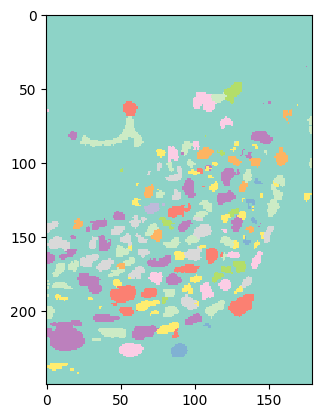

In [9]:
from matplotlib import pyplot as plt
import mplcursors
z = 100
fig, ax = plt.subplots()
ax.imshow(mask[z], cmap="Set3", interpolation='none')
mplcursors.cursor(hover=True)
plt.show()

# io.imsave("test.png", masks[70].astype(np.uint16))

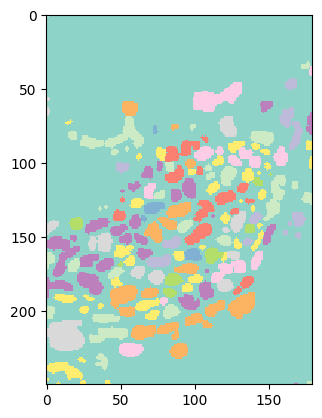

In [10]:
# Boundary seg Mask version
import skimage.io as io
fig, ax = plt.subplots()
ax.imshow(masks_aff[z], cmap="Set3", interpolation='none')
mplcursors.cursor(hover=True)
plt.show()
# io.imsave("test2.png", masks_bound[z].astype(np.uint16))

## Save 

In [73]:
import skimage.io as io
from os.path import isdir, join
from os import makedirs

stitch_directory = os.path.join(root, "built_data", "cellpose_output", model_name, experiment_date + "_stitched", '')
if not isdir(stitch_directory):
    makedirs(stitch_directory)

out_prefix = experiment_date + f"_well{well_int:03}_t{time_int:03}"

io.imsave(join(stitch_directory, out_prefix + "_cp_mask.tif"), mask.astype(np.uint16), check_contrast=False)
io.imsave(join(stitch_directory, out_prefix + "_aff_mask0.tif"), masks_aff0.astype(np.uint16), check_contrast=False)
io.imsave(join(stitch_directory, out_prefix + "_aff_mask6.tif"), masks_aff_6.astype(np.uint16), check_contrast=False)
io.imsave(join(stitch_directory, out_prefix + "_aff_maskn6.tif"), masks_aff_n6.astype(np.uint16), check_contrast=False)
io.imsave(join(stitch_directory, out_prefix + "_im_bkg.tif"), im_bkg, check_contrast=False)
io.imsave(join(stitch_directory, out_prefix + "_im_LoF.tif"), im_LoG, check_contrast=False)

In [53]:
io.imsave(join(stitch_directory, out_prefix + "_aff_mask06.tif"), masks_aff_2.astype(np.uint16), check_contrast=False)

In [78]:
augmented_affinity = agumented_affinity
augmented_affinity[:, :, 0]


array([[ 31,  31,  31,  31,  31,  31,  31,  31,  31,  32,  32,  32,  32,
         32,  32,  32,  32,  32,  33,  33,  33,  33,  33,  33,  33,  33,
         33],
       [  9,   9,   9,  10,  10,  10,  11,  11,  11,   9,   9,   9,  10,
         10,  10,  11,  11,  11,   9,   9,   9,  10,  10,  10,  11,  11,
         11],
       [167, 168, 169, 167, 168, 169, 167, 168, 169, 167, 168, 169, 167,
        168, 169, 167, 168, 169, 167, 168, 169, 167, 168, 169, 167, 168,
        169],
       [  0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   1,   1,
          0,   1,   1,   1,   1,   0,   0,   1,   1,   1,   1,   1,   1,
          1]], dtype=int64)